In [1]:
import streamlit as st
import jsonlines
import random
import pandas as pd
import seaborn as sns
import json
import fileinput
import numpy as np
import nltk
from pprint import pprint
from wordcloud import WordCloud
from textblob_de import TextBlobDE as TextBlob
import re
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from datetime import date
import re
import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2022-06-15 17:41:07.192 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [2]:
#Importing Dataset
olafScholzJsonLines = jsonlines.open("OlafScholz.jl")
#olafScholzTwitter = pd.read_json("OlafScholz.jl", lines = True)
#print("Datensatzlänge: " + str(olafScholzTwitter.info()))
#print(olafScholzTwitter.head())

In [3]:
# Reply Dataframe
# Importing Data into final Dataframe for ML
replyDataFrame = pd.DataFrame(columns = ["tweetid", "datetime", "date", "time", "user", "text"])
#print(replyDataFrame.head())
iterator = 0

for line in olafScholzJsonLines:
    keyResponse = line["response"]
    data = keyResponse["data"]
    newDataRow = [None, None, None, None, None, None]
    userName = line["account_name"]
    newDataRow[4] = userName
    keyResponse = line["response"]
    data = keyResponse["data"]


    for tweet in data:

        tweetTarget = 1
       
        tweetID = tweet["id"]
        authorID = tweet["author_id"]
        datetime = tweet["created_at"][0:10] + ' '+tweet["created_at"][11:19]
        tweetDate = tweet["created_at"][0:10]
        tweetTime = tweet["created_at"][11:19]
        tweetText = tweet["text"]        
        newDataRow[0] = tweetID
        newDataRow[1] = datetime
        newDataRow[2] = tweetDate
        newDataRow[3] = tweetTime
        newDataRow[4] = authorID
        newDataRow[5] = tweetText
        replyDataFrame.loc[len(replyDataFrame)] = newDataRow
    iterator += 1

In [4]:
#print(dir(replyDataFrame))
#print(len(replyDataFrame))
#print(replyDataFrame.shape)
#print(replyDataFrame.head())
# getting the date column ready for datetime operations
replyDataFrame['datetime']= pd.to_datetime(replyDataFrame['datetime'])

In [5]:
#print("----")
#print(replyDataFrame[replyDataFrame["text"].str.contains("RT @Bundeskanzler:")].sort_values("date",ascending = "true").head())

In [6]:
#testing
#print(replyDataFrame["text"].str.contains("RT @Bundeskanzler").head())
#print(replyDataFrame["text"].str.contains("RT @Bundeskanzler").count())

In [7]:
#cleansedTweetDF = replyDataFrame[replyDataFrame["text"].str.contains("RT @Bundeskanzler:") or replyDataFrame["text"].str.contains("!RT @") ]
#print("Size of dataframe :\n"+ str(replyDataFrame.count())+"\n----")
maskBundesKanz = replyDataFrame["text"].str.contains("RT @Bundeskanzler:")
maskNoRT = replyDataFrame["text"].str.contains("RT @")==False
#print("Size of dataframe with RT @Bundeskanzler:\n" + str(replyDataFrame[maskBundesKanz].count())+"\n----")
#print("Size of dataframe without RT @:\n" + str(replyDataFrame[maskNoRT].count())+"\n----")
#cleansedTweetDF contains all Tweets posted directly by Olaf before or after being Kanzler
cleansedTweetDF = replyDataFrame[maskBundesKanz | maskNoRT]
#print("Size of cleansedTweetDF @:\n" + str(cleansedTweetDF.count())+"\n----")
#print(cleansedTweetDF.head())
#cleansedTweetDF has "RT @Bundeskanzler:" still in the tweet. To not have any issues with ML we removed that part of the Tweet in the following parts

In [8]:
# Removing the Text \"RT @Bundeskanzler:\" from the text\n
#print("ReplyDataframe: \n" + str(replyDataFrame[maskBundesKanz].count()))
cleansedAtBundKanzDF = replyDataFrame[maskBundesKanz].copy()
cleansedAtBundKanzDF.text = cleansedAtBundKanzDF.text.str.strip("RT @Bundeskanzler: ")
#print(cleansedAtBundKanzDF.head())                                                           

In [9]:
#appending the sliced versions to the Dataframe and resulting in the expected 4119 Tweets
cleansedTweetDFShort = replyDataFrame[maskNoRT].append(cleansedAtBundKanzDF)
#print(cleansedTweetDFShort.count())
#print(cleansedTweetDFShort.sort_values("date",ascending = False).head())

In [10]:
#Language Detection to check if there are any tweets not in german

#cleansedTweetDFShort.reset_index(inplace=True, drop=True)
from langdetect import detect
cleansedTweetDFShort['language'] = detect(str(cleansedTweetDFShort.text))
print(cleansedTweetDFShort.head())
print("Amount of different Languages found: " + str(cleansedTweetDFShort['language'].nunique()))
uniqueLang = cleansedTweetDFShort['language'].unique()
print(uniqueLang)

cleansedTweetDFShort.drop(cleansedTweetDFShort[cleansedTweetDFShort['language'] != 'de'].index, inplace = True)

                tweetid            datetime        date      time      user  \
12  1508125473842335749 2022-03-27 16:55:07  2022-03-27  16:55:07  38150247   
21  1504398354565976070 2022-03-17 10:04:52  2022-03-17  10:04:52  38150247   
54  1492872048120668161 2022-02-13 14:43:27  2022-02-13  14:43:27  38150247   
55  1492074452796022791 2022-02-11 09:54:05  2022-02-11  09:54:05  38150247   
56  1492074451432873985 2022-02-11 09:54:05  2022-02-11  09:54:05  38150247   

                                                 text language  
12  Die Saarländerinnen und Saarländer haben sich ...       de  
21  Meine persönliche Position ist längst bekannt:...       de  
54  Ich freue mich, wenn Sie und Ihr mir ab heute ...       de  
55  Für die aktuelle Welle der Pandemie gibt es An...       de  
56  Die #Corona-Pandemie und auch die Flutkatastro...       de  
Amount of different Languages found: 1
['de']


In [11]:
# Starting preparing for machine learning and showing state of the dataframe

cleansedTweetDFShort['edited'] = cleansedTweetDFShort['text']

cleansedTweetDFShort

,tweetid,datetime,date,time,user,text,language,edited
12,1508125473842335749,2022-03-27 16:55:07,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...,de,Die Saarländerinnen und Saarländer haben sich ...
21,1504398354565976070,2022-03-17 10:04:52,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...,de,Meine persönliche Position ist längst bekannt:...
54,1492872048120668161,2022-02-13 14:43:27,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",de,"Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1492074452796022791,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...,de,Für die aktuelle Welle der Pandemie gibt es An...
56,1492074451432873985,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Die #Corona-Pandemie und auch die Flutkatastro...,de,Die #Corona-Pandemie und auch die Flutkatastro...
...,...,...,...,...,...,...,...,...
49,1494245849085493251,2022-02-17 09:42:26,2022-02-17,09:42:26,38150247,Gestern Abend habe ich mit @POTUS Biden zur Si...,de,Gestern Abend habe ich mit @POTUS Biden zur Si...
50,1494003008283287560,2022-02-16 17:37:29,2022-02-16,17:37:29,38150247,Die #Corona-Regeln zeigen die erhoffte Wirkung...,de,Die #Corona-Regeln zeigen die erhoffte Wirkung...
51,1493602211829587986,2022-02-15 15:04:51,2022-02-15,15:04:51,38150247,Ich habe Präsident #Putin in Moskau verdeutlic...,de,Ich habe Präsident #Putin in Moskau verdeutlic...
52,1493599012691365903,2022-02-15 14:52:09,2022-02-15,14:52:09,38150247,Der Frieden und die Sicherheit in Europa sind ...,de,Der Frieden und die Sicherheit in Europa sind ...


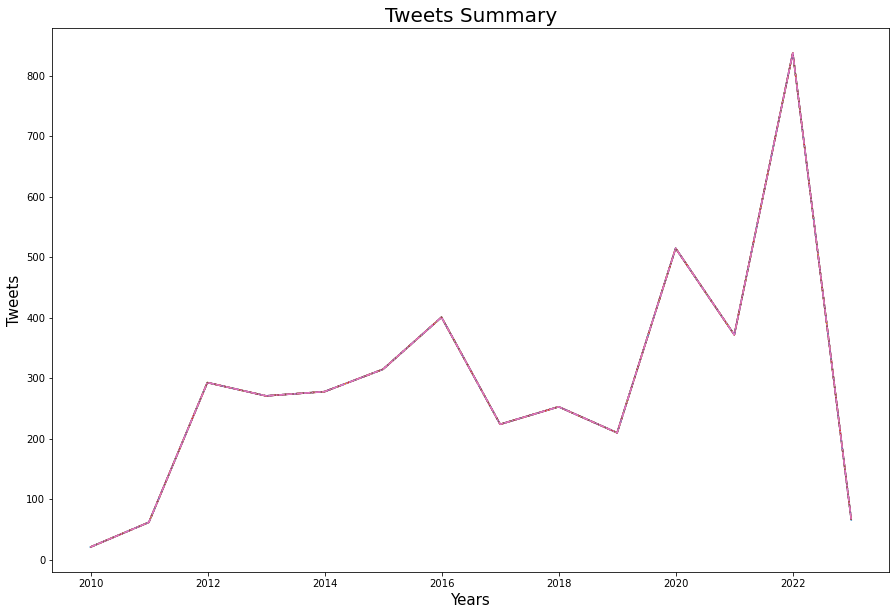

In [12]:
# Plot the number of tweets over time
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=cleansedTweetDFShort.set_index("datetime").groupby(pd.Grouper(freq='Y')).count())
plt.title('Tweets Summary', fontsize=20)
plt.xlabel('Years', fontsize=15)
plt.ylabel('Tweets', fontsize=15)
plt.gca().get_legend().remove()

In [13]:
# Clean the tweets in the column edited

def clean(text):
    text = re.sub(r'@[A-Za-z0-9]+\s?', '', text) #Removed Mentions
    text = re.sub(r'#', '', text) #Removed #
    text = re.sub(r'(.)1+', r'1', text) #cleaned single letters
    text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text) #Removes links
    text = re.sub('@','',text) #Remove @
    text = re.sub('-','',text) #Remove -
    text = re.sub('ä','ae',text) #Remove ä
    text = re.sub('Ä','Ae',text) #Remove Ä
    text = re.sub('ö','oe',text) #Remove Ä
    text = re.sub('Ö','Oe',text) #Remove Ä
    text = re.sub('ü','ue',text) #Remove Ä
    text = re.sub('Ü','Ue',text) #Remove Ä
    return text

cleansedTweetDFShort['edited'] = cleansedTweetDFShort['edited'].apply(clean)

#cleansedTweetDFShort['edited'] = cleansedTweetDFShort['edited'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)

cleansedTweetDFShort

,tweetid,datetime,date,time,user,text,language,edited
12,1508125473842335749,2022-03-27 16:55:07,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...,de,Die Saarlaenderinnen und Saarlaender haben sic...
21,1504398354565976070,2022-03-17 10:04:52,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...,de,Meine persoenliche Position ist laengst bekann...
54,1492872048120668161,2022-02-13 14:43:27,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",de,"Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1492074452796022791,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...,de,Fuer die aktuelle Welle der Pandemie gibt es A...
56,1492074451432873985,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Die #Corona-Pandemie und auch die Flutkatastro...,de,Die CoronaPandemie und auch die Flutkatastroph...
...,...,...,...,...,...,...,...,...
49,1494245849085493251,2022-02-17 09:42:26,2022-02-17,09:42:26,38150247,Gestern Abend habe ich mit @POTUS Biden zur Si...,de,Gestern Abend habe ich mit Biden zur Situation...
50,1494003008283287560,2022-02-16 17:37:29,2022-02-16,17:37:29,38150247,Die #Corona-Regeln zeigen die erhoffte Wirkung...,de,Die CoronaRegeln zeigen die erhoffte Wirkung. ...
51,1493602211829587986,2022-02-15 15:04:51,2022-02-15,15:04:51,38150247,Ich habe Präsident #Putin in Moskau verdeutlic...,de,Ich habe Praesident Putin in Moskau verdeutlic...
52,1493599012691365903,2022-02-15 14:52:09,2022-02-15,14:52:09,38150247,Der Frieden und die Sicherheit in Europa sind ...,de,Der Frieden und die Sicherheit in Europa sind ...


In [14]:
# Cleaning process for the text used by textblob sentiment analysis to optimize results

def cleanforblob(text):
    cleansedTweetDFShort['text'] = cleansedTweetDFShort['text'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
    text = re.sub(r'@[A-Za-z0-9]+\s?', '', text) #Removed Mentions
    text = re.sub(r'#', '', text) #Removed #
    text = re.sub(r'(.)1+', r'1', text) #cleaned single letters
    text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text) #Removes links
    text = re.sub('@','',text) #Remove @
    return text

cleansedTweetDFShort['textforttb'] = cleansedTweetDFShort['text'].apply(cleanforblob)

cleansedTweetDFShort

,tweetid,datetime,date,time,user,text,language,edited,textforttb
12,1508125473842335749,2022-03-27 16:55:07,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...,de,Die Saarlaenderinnen und Saarlaender haben sic...,Die Saarländerinnen und Saarländer haben sich ...
21,1504398354565976070,2022-03-17 10:04:52,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...,de,Meine persoenliche Position ist laengst bekann...,Meine persönliche Position ist längst bekannt:...
54,1492872048120668161,2022-02-13 14:43:27,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",de,"Ich freue mich, wenn Sie und Ihr mir ab heute ...","Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1492074452796022791,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...,de,Fuer die aktuelle Welle der Pandemie gibt es A...,Für die aktuelle Welle der Pandemie gibt es An...
56,1492074451432873985,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Die #Corona-Pandemie und auch die Flutkatastro...,de,Die CoronaPandemie und auch die Flutkatastroph...,Die Corona-Pandemie und auch die Flutkatastrop...
...,...,...,...,...,...,...,...,...,...
49,1494245849085493251,2022-02-17 09:42:26,2022-02-17,09:42:26,38150247,Gestern Abend habe ich mit Biden zur Situation...,de,Gestern Abend habe ich mit Biden zur Situation...,Gestern Abend habe ich mit Biden zur Situation...
50,1494003008283287560,2022-02-16 17:37:29,2022-02-16,17:37:29,38150247,Die #Corona-Regeln zeigen die erhoffte Wirkung...,de,Die CoronaRegeln zeigen die erhoffte Wirkung. ...,Die Corona-Regeln zeigen die erhoffte Wirkung....
51,1493602211829587986,2022-02-15 15:04:51,2022-02-15,15:04:51,38150247,Ich habe Präsident #Putin in Moskau verdeutlic...,de,Ich habe Praesident Putin in Moskau verdeutlic...,Ich habe Präsident Putin in Moskau verdeutlich...
52,1493599012691365903,2022-02-15 14:52:09,2022-02-15,14:52:09,38150247,Der Frieden und die Sicherheit in Europa sind ...,de,Der Frieden und die Sicherheit in Europa sind ...,Der Frieden und die Sicherheit in Europa sind ...


In [15]:
# Changing the type of the columns with text from the tweets to string

cleansedTweetDFShort = cleansedTweetDFShort.astype({'edited':'string'})
cleansedTweetDFShort = cleansedTweetDFShort.astype({'text':'string'})
cleansedTweetDFShort = cleansedTweetDFShort.astype({'textforttb':'string'})
print(cleansedTweetDFShort.dtypes)
#cleansedTweetDFShort.head()

tweetid               object
datetime      datetime64[ns]
date                  object
time                  object
user                  object
text                  string
language              object
edited                string
textforttb            string
dtype: object


In [16]:
# Extra DF for wordcloud

#Change number of tweets here for testing etc. and show used tweets

cleansedTweetDFShort10 = cleansedTweetDFShort.copy()
cleansedTweetDFShort10

,tweetid,datetime,date,time,user,text,language,edited,textforttb
12,1508125473842335749,2022-03-27 16:55:07,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...,de,Die Saarlaenderinnen und Saarlaender haben sic...,Die Saarländerinnen und Saarländer haben sich ...
21,1504398354565976070,2022-03-17 10:04:52,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...,de,Meine persoenliche Position ist laengst bekann...,Meine persönliche Position ist längst bekannt:...
54,1492872048120668161,2022-02-13 14:43:27,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",de,"Ich freue mich, wenn Sie und Ihr mir ab heute ...","Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1492074452796022791,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...,de,Fuer die aktuelle Welle der Pandemie gibt es A...,Für die aktuelle Welle der Pandemie gibt es An...
56,1492074451432873985,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Die #Corona-Pandemie und auch die Flutkatastro...,de,Die CoronaPandemie und auch die Flutkatastroph...,Die Corona-Pandemie und auch die Flutkatastrop...
...,...,...,...,...,...,...,...,...,...
49,1494245849085493251,2022-02-17 09:42:26,2022-02-17,09:42:26,38150247,Gestern Abend habe ich mit Biden zur Situation...,de,Gestern Abend habe ich mit Biden zur Situation...,Gestern Abend habe ich mit Biden zur Situation...
50,1494003008283287560,2022-02-16 17:37:29,2022-02-16,17:37:29,38150247,Die #Corona-Regeln zeigen die erhoffte Wirkung...,de,Die CoronaRegeln zeigen die erhoffte Wirkung. ...,Die Corona-Regeln zeigen die erhoffte Wirkung....
51,1493602211829587986,2022-02-15 15:04:51,2022-02-15,15:04:51,38150247,Ich habe Präsident #Putin in Moskau verdeutlic...,de,Ich habe Praesident Putin in Moskau verdeutlic...,Ich habe Präsident Putin in Moskau verdeutlich...
52,1493599012691365903,2022-02-15 14:52:09,2022-02-15,14:52:09,38150247,Der Frieden und die Sicherheit in Europa sind ...,de,Der Frieden und die Sicherheit in Europa sind ...,Der Frieden und die Sicherheit in Europa sind ...


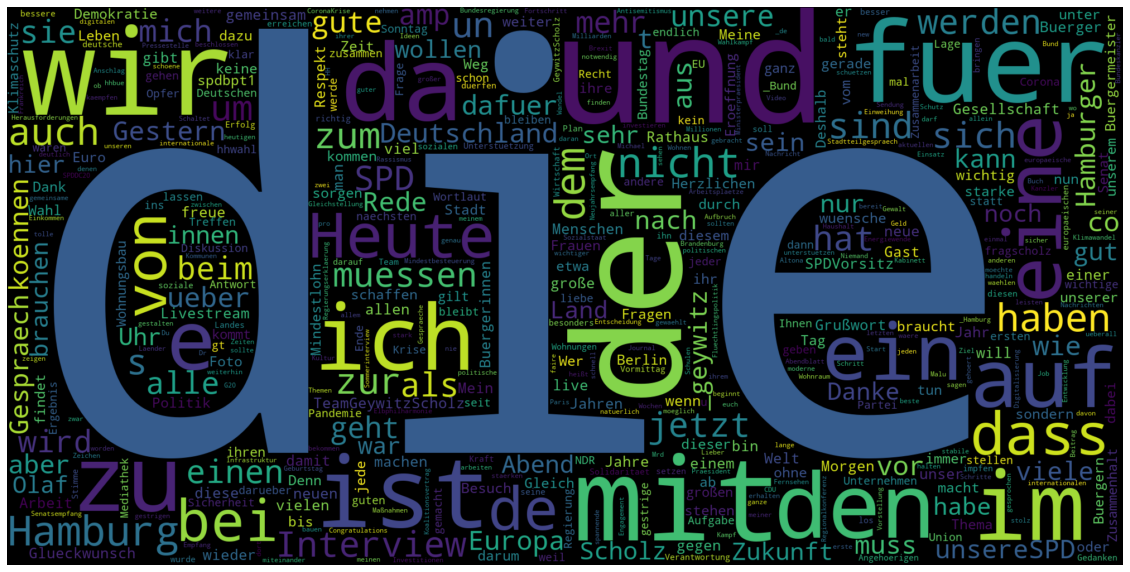

In [17]:
# Plot Word Cloud not cleaned

plt.figure(figsize = (20,20))

allWords = ' '.join([txt for txt in cleansedTweetDFShort10['edited']])
wordCloud = WordCloud(max_words=500, width=2000, height = 1000, 
                      max_font_size = 1000, collocations=False).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [18]:
# Defining set containing all stopwords in German. (Stopwords: Word with no relevance for analysis)
# Source for Stopwordlist: https://github.com/stopwords-iso/stopwords-de/blob/master/stopwords-de.json

# Making statement text in lower case
cleansedTweetDFShort10['edited']=cleansedTweetDFShort10['edited'].str.lower()

# Cleaning text from stopwords
with open('stopwords-de.json','r') as file:
    stopwordlistgerman = json.load(file)

STOPWORDS = set(stopwordlistgerman)

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

cleansedTweetDFShort10['edited'] = cleansedTweetDFShort10['edited'].apply(lambda text: cleaning_stopwords(text))
#cleansedTweetDFShort10['edited'].head(10)

In [19]:
# Cleaning text from stopwords using the german stopword list from nltk.corpus

from nltk.corpus import stopwords

my_words = ['fuer', 'ueber', 'dafuer', 'ist', 'sind']

STOPLISTnltk = set(stopwords.words('german') + list(my_words))

def clean_tweet(text):
    return " ".join([word for word in str(text).split() if word not in STOPLISTnltk])

cleansedTweetDFShort10['edited'] = cleansedTweetDFShort10['edited'].apply(lambda text: clean_tweet(text))
#cleansedTweetDFShort10.head(10)

In [20]:
# Cleaning text from english stopwords
# Source for Stopwordlist: https://countwordsfree.com/stopwords
# Cleaning text from stopwords
with open('stop_words_english.json','r',encoding='utf-8') as file:
    stopwordlistenglish = json.load(file)

STOPWORDS = set(stopwordlistenglish)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
cleansedTweetDFShort10['edited'] = cleansedTweetDFShort10['edited'].apply(lambda text: cleaning_stopwords(text))
#cleansedTweetDFShort10['edited'].head(10)

In [21]:
#Remove punctations

#import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
cleansedTweetDFShort10['edited']= cleansedTweetDFShort10['edited'].apply(lambda x: cleaning_punctuations(x))
#cleansedTweetDFShort10['edited'].head(10)

In [22]:
# Applying Stemming

from nltk.stem import PorterStemmer
 
porter = PorterStemmer()

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
cleansedTweetDFShort10['edited']= cleansedTweetDFShort10['edited'].apply(lambda x: stemming_on_text(x))
#cleansedTweetDFShort10['edited'].head()

In [23]:
# The NLTK lemmatizer and stemmer classes
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('german')

# I use the POS tagging from NLTK to retain only adjectives, verbs, adverbs 
# and nouns as a base for for lemmatization.
def get_lemmas(tweet): 
    
    # A dictionary to help convert Treebank tags to WordNet
    treebank2wordnet = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    
    postag = ''
    lemmas_list = []
    
    for word, tag in pos_tag(word_tokenize(tweet)):
        if tag.startswith("JJ")     \
            or tag.startswith("RB") \
            or tag.startswith("VB") \
            or tag.startswith("NN"):
                
            try:
                postag = treebank2wordnet[tag[:2]]
            except:
                postag = 'n'                
                            
            lemmas_list.append(lemmatizer.lemmatize(word.lower(), postag))    
    
    return lemmas_list

In [24]:
# Starts the lemmatization process
def get_lemmatized(tweet):
   
    all_tokens_string = ''
    filtered = []
    tokens = []

    # lemmatize
    tokens = [token for token in get_lemmas(tweet)]
    
    # filter
    filtered = clean_tweet(tokens)

    # join everything into a single string
    all_tokens_string = ''.join(filtered)
    
    return all_tokens_string

In [25]:
# Get the lemmatized tweets and put the result in an "lematized" text column

# If this code failes due to missing download, uncomment following line
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

edited = ''
for i, row in cleansedTweetDFShort10.iterrows():
    edited = get_lemmatized(cleansedTweetDFShort10.loc[i]['edited'])
    if len(edited) > 0:
        cleansedTweetDFShort10.at[i,'lematized'] = edited
    else:
        cleansedTweetDFShort10.at[i,'lematized'] = None   
        
#cleansedTweetDFShort10

In [26]:
# After lemmatization, some tweets may end up with the same words
# Remove duplicates
cleansedTweetDFShort10.drop_duplicates(subset=['edited'], inplace=True)
cleansedTweetDFShort10.dropna(inplace=True)

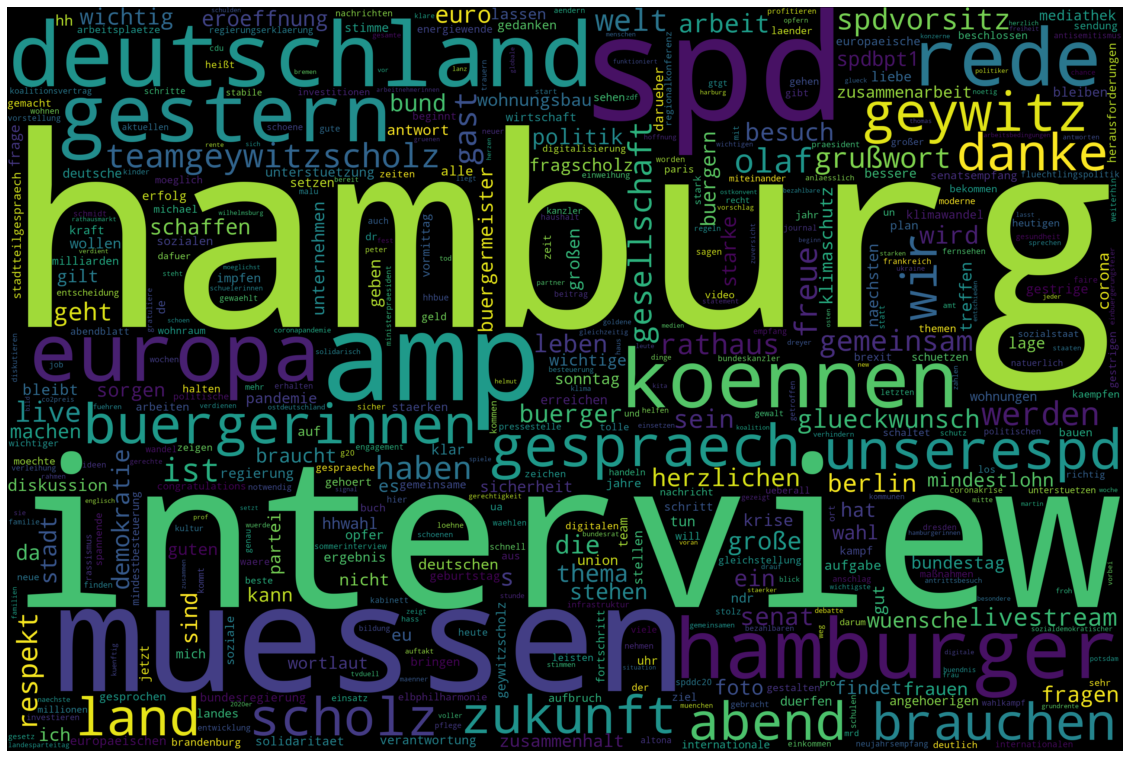

In [27]:
# Plot Word Cloud after cleaning
plt.figure(figsize = (20,20))
cleanedwords = ' '.join([txt for txt in cleansedTweetDFShort10['edited']])
wordCloud = WordCloud(max_words = 500, width=3000, height = 2000, max_font_size = 1000, 
                      collocations=False).generate(cleanedwords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [28]:
# Sentiment Analysis with TextBlob 

# Get Polarity and Subjectivity

# Subjectivity quantifies the amount of personal opinion and factual information contained in the text. 
# The higher subjectivity means that the text contains personal opinion rather than factual information. 
# 0 means low personal opinion and 1 a lot of personal opinion

# If this code failes due to missing download, uncomment following line
# nltk.download("punkt")

def getS (text):
    return TextBlob(text).sentiment.subjectivity

# Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment.

def getP (text):
    return TextBlob(text).sentiment.polarity


cleansedTweetDFShort10['Personal Opinion (Subjectivity)'] = cleansedTweetDFShort10['textforttb'].apply(getS)
cleansedTweetDFShort10['Sentiment (Polarity)'] = cleansedTweetDFShort10['textforttb'].apply(getP)

#cleansedTweetDFShort10

In [29]:
# Create a function to compute analysis of the Sentiment of the tweets
# Range for neutral betweem -0.15 and 0.15 because of 

def getA(score):
    if score < -0.15:
        return 'negative'
    elif -0.15 <= score <= 0.15:
        return 'neutral'
    else:
        return 'positive'

cleansedTweetDFShort10['Analysis'] = cleansedTweetDFShort10['Sentiment (Polarity)'].apply(getA)
#cleansedTweetDFShort10

In [30]:
# Dataframe for Visualization

sortedDf = cleansedTweetDFShort10.sort_values(by=['Sentiment (Polarity)'])
sortedDf = sortedDf.astype({'Analysis':'string'})
print(sortedDf.dtypes)
sortedDf.reset_index(inplace=True, drop=True) # Reset index
sortedDf.head()

tweetid                                    object
datetime                           datetime64[ns]
date                                       object
time                                       object
user                                       object
text                                       string
language                                   object
edited                                     object
textforttb                                 string
lematized                                  object
Personal Opinion (Subjectivity)           float64
Sentiment (Polarity)                      float64
Analysis                                   string
dtype: object


,tweetid,datetime,date,time,user,text,language,edited,textforttb,lematized,Personal Opinion (Subjectivity),Sentiment (Polarity),Analysis
0,646949323536732161,2015-09-24 07:28:33,2015-09-24,07:28:33,38150247,Trauer um den ehemaligen Senator Prof. Dr. Han...,de,trauer ehemaligen senator prof dr hansjoachim ...,Trauer um den ehemaligen Senator Prof. Dr. Han...,"['trauer', 'ehemaligen', 'senator', 'prof', 'd...",0.0,-1.0,negative
1,1321818909163606022,2020-10-29 14:19:20,2020-10-29,14:19:20,38150247,Furchtbare Nachrichten erreichen uns aus Frank...,de,furchtbare nachrichten erreichen frankreich 3 ...,Furchtbare Nachrichten erreichen uns aus Frank...,"['furchtbare', 'nachrichten', 'erreichen', 'fr...",0.0,-1.0,negative
2,29374828794,2010-11-01 14:04:06,2010-11-01,14:04:06,38150247,Das Bild des Senats ist katastrophal http://go...,de,bild senats katastrophal,Das Bild des Senats ist katastrophal,"['bild', 'senats', 'katastrophal']",0.0,-1.0,negative
3,517647962839580672,2014-10-02 12:11:06,2014-10-02,12:11:06,38150247,Anders als gehofft hat es heute keine Entschei...,de,gehofft entscheidung verfahren fahrrinnenanpas...,Anders als gehofft hat es heute keine Entschei...,"['gehofft', 'entscheidung', 'verfahren', 'fahr...",0.0,-1.0,negative
4,785413527167172608,2016-10-10 09:35:51,2016-10-10,09:35:51,38150247,Wir trauern um Barbara Kisseler https://t.co/a...,de,trauern barbara kisseler stconkak6ptg7u,Wir trauern um Barbara Kisseler s://t.co/nkAK6...,"['trauern', 'barbara', 'kisseler', 'stconkak6p...",0.0,-1.0,negative


In [31]:
# Show texts with Polarity and Analysis 

#for i in range (0, sortedDf.shape[0]):
    #print(sortedDf['text'][i])
    #print(sortedDf['Personal Opinion (Subjectivity)'][i])
    #print(sortedDf['Sentiment (Polarity)'][i])
    #print(sortedDf['Analysis'][i])
    #print()

In [32]:
# Print Positive tweets

#j=1;

#for i in range(0, sortedDf.shape[0]):
    #if(sortedDf['Analysis'][i] == 'positive'):
        #print(str(j) + ') ' + sortedDf['text'][i])
        #print(sortedDf['Personal Opinion (Subjectivity)'][i])
        #print(sortedDf['Sentiment (Polarity)'][i])
        #print(sortedDf['Analysis'][i])
        #print()
        #j=j+1

In [33]:
# Print Negative tweets

#j=1;

#for i in range(0, sortedDf.shape[0]):
    #if(sortedDf['Analysis'][i] == 'negative'):
        #print(str(j) + ') ' + sortedDf['text'][i])
        #print(sortedDf['Personal Opinion (Subjectivity)'][i])
        #print(sortedDf['Sentiment (Polarity)'][i])
        #print(sortedDf['Analysis'][i])
        #print()
        #j=j+1

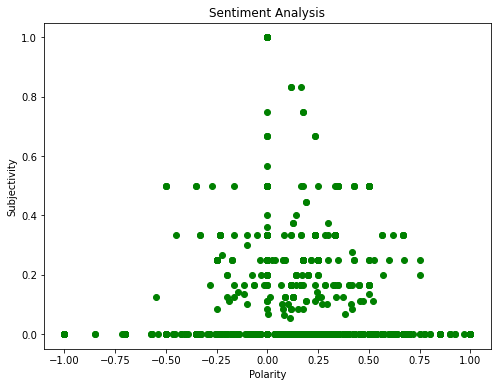

In [34]:
#Plot polarity and subjectivity as an scatterplot

plt.figure(figsize=(8,6))

for i in range (0, sortedDf.shape[0]):
    plt.scatter(sortedDf['Sentiment (Polarity)'][i], sortedDf['Personal Opinion (Subjectivity)'][i], color='Green')
                
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [35]:
# Get the percentage of positive tweets identified by textblob

ptweets = sortedDf[sortedDf.Analysis =="positive"] 

print("Positive Tweets in percent: "+str(round((ptweets.shape[0]/sortedDf.shape[0])*100, 1)) + '%')

Positive Tweets in percent: 31.4%


In [36]:
# Get the negative of positive tweets identified by textblob

neutweets = sortedDf[sortedDf.Analysis =="neutral"] 

print("Neutral Tweets in percent: "+str(round((neutweets.shape[0]/sortedDf.shape[0])*100, 1)) + '%')

Neutral Tweets in percent: 62.6%


In [37]:
# Get the negative of positive tweets identified by textblob

ntweets = sortedDf[sortedDf.Analysis =="negative"] 

print("Negative Tweets in percent: "+str(round((ntweets.shape[0]/sortedDf.shape[0])*100, 1)) + '%')

Negative Tweets in percent: 6.0%


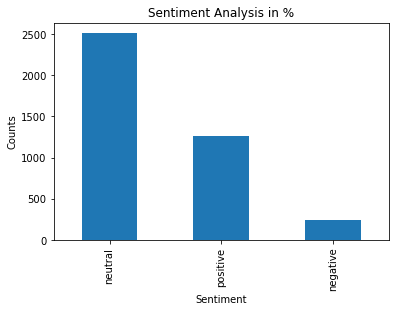

In [38]:
# Show Analysis as a diagram

sortedDf['Analysis'].value_counts()

plt.title('Sentiment Analysis in %')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
sortedDf['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [39]:
# Huge thanks to Carlos Catalão Alves who did an amazing Job analyzing English Tweeter Datasets
# https://github.com/ccatalao/covid19vaccine-emotions/blob/master/olstorm.ipynb

# To avoid repetitions in our code, here are some plotting functions which will be used often

def plot_sentiment_period(df, info):
    
    # Using the mean values of sentiment for each period
    df1 = df.groupby(df['datetime'].dt.to_period(info['period'])).mean()

    df1.reset_index(inplace=True)
    df1['datetime'] = pd.PeriodIndex(df1['datetime']).to_timestamp()
    plot_df = pd.DataFrame(df1, df1.index, info['cols'])

    plt.figure(figsize=(15, 10))
    ax = sns.lineplot(data=plot_df, linewidth = 3, dashes = False)
    plt.legend(loc='best', fontsize=15)
    plt.title(info['title'], fontsize=20)
    plt.xlabel(info['xlab'], fontsize=15)
    plt.ylabel(info['ylab'], fontsize=15)
    plt.tight_layout()
    #plt.savefig('images/' + info['fname'])    
    return


def plot_fractions(props, title, fname):
    
    plt1 = props.plot(kind='bar', stacked=False, figsize=(16,5), colormap='Spectral') 
    plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Sentiment', fontweight='bold', fontsize=18)
    plt.xticks(rotation=0,fontsize=14)
    #plt.ylim(0, 0.5)
    plt.ylabel('Fraction of Tweets', fontweight='bold', fontsize=18)
    plt1.set_title(label=title, fontweight='bold', size=20)
    plt.tight_layout()
    #plt.savefig('images/' + fname + '.png')
    
    return


def plot_frequency_chart(info):
    
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.set_context("notebook", font_scale=1)    
    ax = sns.barplot(x=info['x'], y=info['y'], data=info['data'], palette=(info['pal']))
    ax.set_title(label=info['title'], fontweight='bold', size=18)
    plt.ylabel(info['ylab'], fontsize=16)
    plt.xlabel(info['xlab'], fontsize=16)
    plt.xticks(rotation=info['angle'],fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    #plt.savefig('images/' + info['fname'])
    
    return

In [40]:
# Sorting Dataframe after values descending

cleansedTweetDFShort10.sort_values("date",ascending = False)

,tweetid,datetime,date,time,user,text,language,edited,textforttb,lematized,Personal Opinion (Subjectivity),Sentiment (Polarity),Analysis
0,1515588838562971650,2022-04-17 07:11:52,2022-04-17,07:11:52,38150247,Ich wünsche Ihnen und Ihren Familien frohe #Os...,de,wuensche familien frohe ostern paar kraft hoff...,Ich wünsche Ihnen und Ihren Familien frohe Ost...,"['wuensche', 'familien', 'frohe', 'ostern', 'p...",0.0,0.500000,positive
1,1514644785818058757,2022-04-14 16:40:32,2022-04-14,16:40:32,38150247,Meine Solidarität gilt _Lauterbach: Jeder in D...,de,solidaritaet gilt lauterbach deutschland meinu...,Meine Solidarität gilt _Lauterbach: Jeder in D...,"['solidaritaet', 'gilt', 'lauterbach', 'deutsc...",0.0,0.000000,neutral
2,1514291545742184451,2022-04-13 17:16:53,2022-04-13,17:16:53,38150247,"Sie haben Hilfe organisiert, Kräfte gebündelt ...",de,hilfe organisiert kraefte gebuendelt gezeigt k...,"Sie haben Hilfe organisiert, Kräfte gebündelt ...","['hilfe', 'kraefte', 'gebuendelt', 'gezeigt', ...",0.0,0.000000,neutral
3,1514256817613905929,2022-04-13 14:58:53,2022-04-13,14:58:53,38150247,Verantwortung übernehmen heißt: Deutschland li...,de,verantwortung uebernehmen heißt deutschland li...,Verantwortung übernehmen heißt: Deutschland li...,"['verantwortung', 'uebernehmen', 'heißt', 'deu...",1.0,0.000000,neutral
4,1513955069867274245,2022-04-12 18:59:51,2022-04-12,18:59:51,38150247,Die Sanktionen gegen #Russland sind notwendig ...,de,sanktionen russland notwendig wirksam großer w...,Die Sanktionen gegen Russland sind notwendig u...,"['sanktionen', 'russland', 'notwendig', 'wirks...",0.0,0.233333,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6414,2177208219,2009-06-15 12:40:20,2009-06-15,12:40:20,38150247,"Interview im Deutschlandfunk: ""Die Rettung von...",de,interview deutschlandfunk die rettung arbeitsp...,"Interview im Deutschlandfunk: ""Die Rettung von...","['interview', 'deutschlandfunk', 'die', 'rettu...",0.0,0.500000,positive
6415,2177207840,2009-06-15 12:40:18,2009-06-15,12:40:18,38150247,Olaf Scholz zu Gast bei Anne Will: Olaf Scholz...,de,olaf scholz gast anne will olaf scholz diskuti...,Olaf Scholz zu Gast bei Anne Will: Olaf Scholz...,"['olaf', 'scholz', 'gast', 'anne', 'olaf', 'sc...",0.0,0.000000,neutral
6416,2114915590,2009-06-11 08:41:02,2009-06-11,08:41:02,38150247,Wirtschaftliche und soziale Herausforderungen ...,de,wirtschaftliche soziale herausforderungen jahr...,Wirtschaftliche und soziale Herausforderungen ...,"['wirtschaftliche', 'soziale', 'herausforderun...",0.0,0.700000,positive
6417,2078739068,2009-06-08 17:44:00,2009-06-08,17:44:00,38150247,Interview mit dem Berliner Kurier am Sonntag: ...,de,interview berliner kurier sonntag staatlichen ...,Interview mit dem Berliner Kurier am Sonntag: ...,"['interview', 'berliner', 'kurier', 'sonntag',...",0.0,1.000000,positive


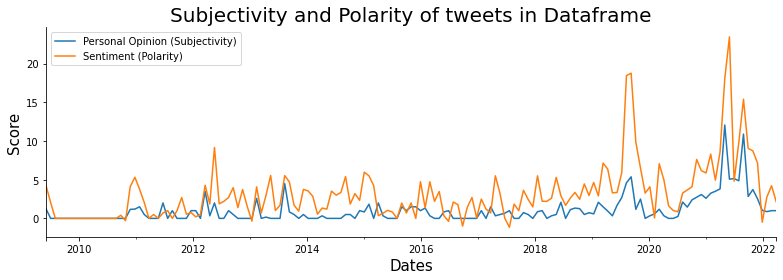

In [41]:
# Diagram to show sentiment and polarity of tweets between dates 

Dfwithdatesasindex = cleansedTweetDFShort10[['datetime', 'Personal Opinion (Subjectivity)', 'Sentiment (Polarity)']].copy()

Dfwithdatesasindex.set_index('datetime',inplace=True)

#Resampled for better visualization to sum of 30 days

Dfwithdatesasindex = Dfwithdatesasindex.resample('30D').sum()


Dfwithdatesasindex=Dfwithdatesasindex[(Dfwithdatesasindex.index<=Dfwithdatesasindex.index.max()) & (Dfwithdatesasindex.index>=Dfwithdatesasindex.index.min())]
Dfwithdatesasindex.plot(figsize=(11,4));
plt.ylabel('Score', fontsize=15)
plt.xlabel('Dates', fontsize=15)
plt.legend().set_visible(True)
plt.title('Subjectivity and Polarity of tweets in Dataframe', fontsize=20)
plt.tight_layout()
sns.despine(top=True)  
plt.show()

In [42]:
# Word Counter table
# Creating a new column with the number of words in each tweet

cleansedTweetDFShort10['word_count'] = cleansedTweetDFShort10.apply(lambda x: len(x['edited'].split()),axis=1)
t = pd.DataFrame(cleansedTweetDFShort10['word_count'].describe()).T
t

,count,mean,std,min,25%,50%,75%,max
word_count,4012.0,10.102193,5.526349,0.0,6.0,9.0,15.0,29.0


In [43]:
# Word frequency
# We need these imports for the wordcloud representation
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter    # Counts the most common items in a list

In [44]:
def join_edited_string(edited_tweets):
    
    edited_string = ''
    for row in edited_tweets:
        edited_string = edited_string + '' + row
        
    return edited_string

def get_trigrams(trigrams, top_grams):
    
    grams_str = []
    data = []

    gram_counter = Counter(trigrams)
    
    for grams in gram_counter.most_common(10):
        gram = ''
        grams_str = grams[0]
        grams_str_count = []
        for n in range(0,3):
            gram = gram + grams_str[n] + ' '
        grams_str_count.append(gram)
        grams_str_count.append(grams[1])
        data.append(grams_str_count)
        print(grams_str_count)

    df = pd.DataFrame(data, columns = ['Grams', 'Count'])

    return df

In [45]:
# Remove blanks and - from column edited

#cleansedTweetDFShort['edited'] = cleansedTweetDFShort['edited'].replace(r'\s+', ' ', regex=True)
#cleansedTweetDFShort['edited'] = cleansedTweetDFShort['edited'].replace('-', '', regex=True)

def cleannew(text):
    text = re.sub(r'-', '', text) #Removed Mentions
    
    return text

cleansedTweetDFShort['edited'] = cleansedTweetDFShort['edited'].apply(cleannew)

#cleansedTweetDFShort['edited'] = cleansedTweetDFShort['edited'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)

cleansedTweetDFShort

#cleansedTweetDFShort['edited']

,tweetid,datetime,date,time,user,text,language,edited,textforttb
12,1508125473842335749,2022-03-27 16:55:07,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...,de,Die Saarlaenderinnen und Saarlaender haben sic...,Die Saarländerinnen und Saarländer haben sich ...
21,1504398354565976070,2022-03-17 10:04:52,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...,de,Meine persoenliche Position ist laengst bekann...,Meine persönliche Position ist längst bekannt:...
54,1492872048120668161,2022-02-13 14:43:27,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",de,"Ich freue mich, wenn Sie und Ihr mir ab heute ...","Ich freue mich, wenn Sie und Ihr mir ab heute ..."
55,1492074452796022791,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...,de,Fuer die aktuelle Welle der Pandemie gibt es A...,Für die aktuelle Welle der Pandemie gibt es An...
56,1492074451432873985,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Die #Corona-Pandemie und auch die Flutkatastro...,de,Die CoronaPandemie und auch die Flutkatastroph...,Die Corona-Pandemie und auch die Flutkatastrop...
...,...,...,...,...,...,...,...,...,...
49,1494245849085493251,2022-02-17 09:42:26,2022-02-17,09:42:26,38150247,Gestern Abend habe ich mit Biden zur Situation...,de,Gestern Abend habe ich mit Biden zur Situation...,Gestern Abend habe ich mit Biden zur Situation...
50,1494003008283287560,2022-02-16 17:37:29,2022-02-16,17:37:29,38150247,Die #Corona-Regeln zeigen die erhoffte Wirkung...,de,Die CoronaRegeln zeigen die erhoffte Wirkung. ...,Die Corona-Regeln zeigen die erhoffte Wirkung....
51,1493602211829587986,2022-02-15 15:04:51,2022-02-15,15:04:51,38150247,Ich habe Präsident #Putin in Moskau verdeutlic...,de,Ich habe Praesident Putin in Moskau verdeutlic...,Ich habe Präsident Putin in Moskau verdeutlich...
52,1493599012691365903,2022-02-15 14:52:09,2022-02-15,14:52:09,38150247,Der Frieden und die Sicherheit in Europa sind ...,de,Der Frieden und die Sicherheit in Europa sind ...,Der Frieden und die Sicherheit in Europa sind ...


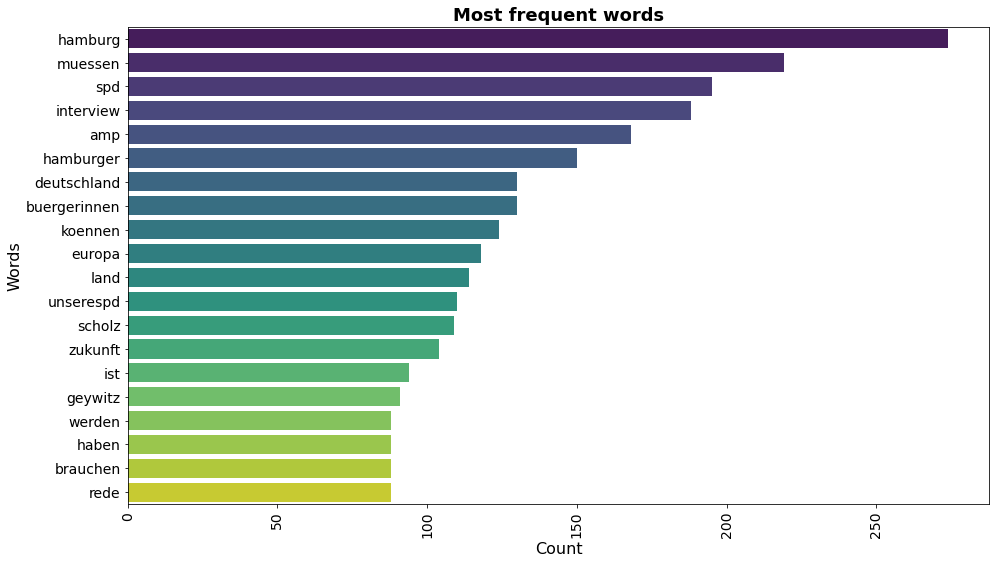

In [46]:
# Show the diagram of the most used words 

# Join all the edited tweets in one single string
joined_string = join_edited_string(cleansedTweetDFShort10['edited'])

# Get tokens
tokens = joined_string.split(' ')

#Remove some unwanted characters

tokens = [string for string in tokens if string != ""]
tokens = [string for string in tokens if string != "–"]
tokens = [string for string in tokens if string != "–"]

# get trigrams
trigrams = nltk.trigrams(tokens)

word_counter = Counter(tokens)
df_counter = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
info = {'data': df_counter, 'x': 'freq', 'y': 'word',
       'xlab': 'Count', 'ylab': 'Words', 'pal':'viridis',
       'title': 'Most frequent words',
       'fname':'word_frequency_before_onlinestorm.png',
       'angle': 90}
plot_frequency_chart(info)

['olaf scholz gespraech ', 11]
['ein neuer sozialdemokratischer ', 10]
['neuer sozialdemokratischer aufbruch ', 10]
['sozialdemokratischer aufbruch 2020er ', 10]
['aufbruch 2020er jahre ', 10]
['ausfuehrlicheren einblick findet ', 9]
['einblick findet text ', 9]
['findet text ein ', 9]
['text ein neuer ', 9]
['gespraech buergerinnen buergern ', 9]


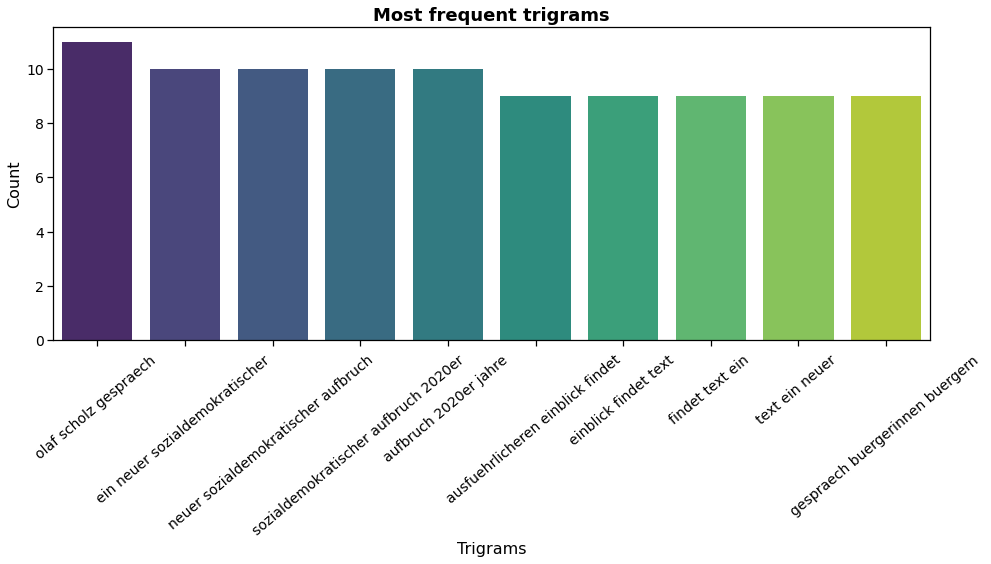

In [47]:
# plot trigram frequency
df_trigrams = get_trigrams(trigrams, 10)
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': 'Trigrams', 'ylab': 'Count', 'pal':'viridis',
       'title': 'Most frequent trigrams',
       'fname':'trigrams_frequency_before_onlinestorm.png',
       'angle': 40}
plot_frequency_chart(info)

In [48]:
# LDATopics extraction
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_top_n_words(n, n_topics, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:, index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            try:
                topic_words.append(the_word.encode('ascii').decode('utf-8'))
            except:
                pass
        top_words.append(", ".join(topic_words))         
    return top_words

In [49]:
# LDA topics
def get_topics(edited, n_topics, n_words):

    eds = edited.values
    
    vec = TfidfVectorizer(use_idf=True, smooth_idf=True)
    document_term_matrix = vec.fit_transform(eds)
    
    model = LatentDirichletAllocation(n_components=n_topics)
    topic_matrix = model.fit_transform(document_term_matrix)
    
    keys = get_keys(topic_matrix)
    categories, counts = keys_to_counts(keys)
    top_n_words = get_top_n_words(n_words, n_topics, keys, document_term_matrix, vec)

    topics = ['Topic {}: \n'.format(i + 1) + top_n_words[i] for i in categories]
    data=[]
    for i, topic in enumerate(topics):
        tmp = []
        tmp.append(topic)
        tmp.append(counts[i])
        data.append(tmp)
    df_topics = pd.DataFrame(data, columns = ['Topics', 'Count'])
    
    return df_topics

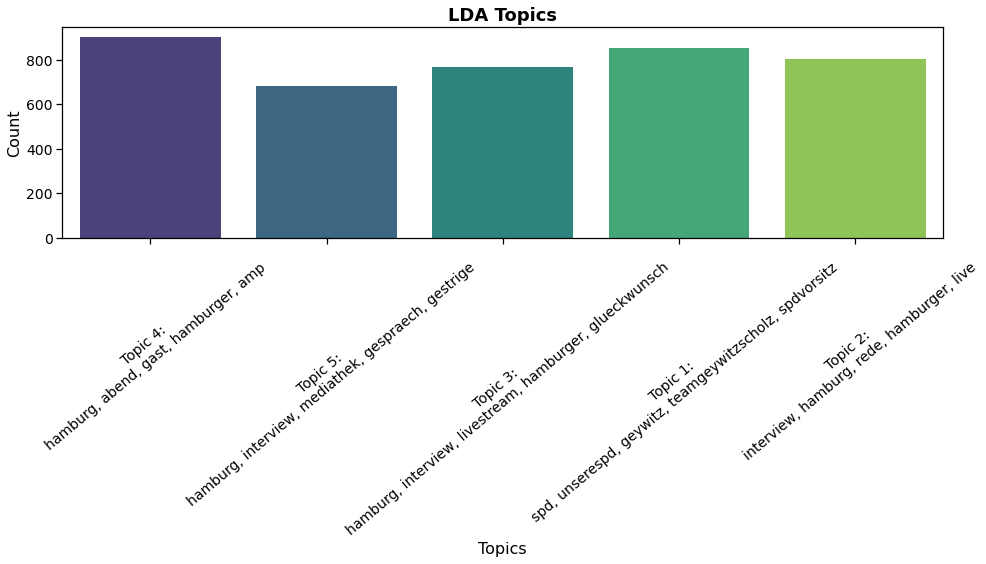

In [50]:
# LDA topics

# LDA (Latent Dirichlet Allocation) is an unsupervised machine learning technique that is increasingly popular in most text mining toolkits. 
# It is used to find topics 
# https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158

df_topics = get_topics(cleansedTweetDFShort10['lematized'], 5, 5)
info = {'data': df_topics, 'x': 'Topics', 'y': 'Count',
       'xlab': 'Topics', 'ylab': 'Count', 'pal':'viridis',
       'title': 'LDA Topics',
       'fname':'LDA_Topics.png',
       'angle': 40}
plot_frequency_chart(info)

In [51]:
# Emotion Analysis

warnings.filterwarnings("ignore", category=DeprecationWarning)

emotionDF = cleansedTweetDFShort10.copy()

In [52]:
# Emotion Analyse

import termcolor
import sys
from termcolor import colored, cprint

# Translate the english row into german by using the Google Translator for translation

# Importing the data from the NCR lexicon
lexicon = pd.read_csv('NCR-lexicon_german2.csv', header= 0,
                        encoding= 'unicode_escape', sep =';')
# Drop last columns
lexicon = lexicon.iloc[: , :12]
lexicon['cleaned']=lexicon['cleaned'].str.lower()
lexicon = lexicon.drop_duplicates(subset=['cleaned'], keep='first', inplace=False, ignore_index=False)

In [53]:
lexicon.squeeze()
#lexicon.dtypes()

,Woerter,cleaned,Positiv,Negativ,Wut,Vorfreude,Ekel,Furcht,Freude,Traurigkeit,Ueberraschung,Vertrauen
0,verblfft,verbluefft,0,0,0,0,0,0,0,0,0,0
1,Abakus,abakus,0,0,0,0,0,0,0,0,0,1
2,aufgeben,aufgeben,0,1,0,0,0,1,0,1,0,0
3,verlassen,verlassen,0,1,1,0,0,1,0,1,0,0
4,Aufgabe,aufgabe,0,1,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14177,Zone,zone,0,0,0,0,0,0,0,0,0,0
14178,Zoo,zoo,0,0,0,0,0,0,0,0,0,0
14179,zoologisch,zoologisch,0,0,0,0,0,0,0,0,0,0
14180,Zoologie,zoologie,0,0,0,0,0,0,0,0,0,0


In [54]:
# Cleaning Emotiontext

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag


In [55]:
# Let's create a list of the emotions used
emotions = ['Wut', 'Vorfreude','Ekel','Furcht', 'Freude','Traurigkeit', 'Ueberraschung', 'Vertrauen']

emotionDF['edited'] = emotionDF['edited'].replace('„', '', regex=True)
emotionDF['edited'] = emotionDF['edited'].replace('“', '', regex=True)

# Join all the edited tweets in one single string
joined_string = join_edited_string(emotionDF['edited'])

# Get tokens
tokens = joined_string.split(' ')

In [56]:
unique_words = set(tokens)

word_to_ind = dict((word, i) for i, word in enumerate(unique_words))
ind_to_word = dict((i, word) for i, word in enumerate(unique_words))

In [57]:
# Create a list of words to highlight 
def get_words(word_list, emotions):
    
    words_emotion_idx = []
    
    for i, word in enumerate(word_list):
        word = stemmer.stem(word.lower())
        result = lexicon[lexicon.cleaned == word]
        if not result.empty:
            for emotion in emotions:
                if result[emotion].any() > 0:
                    words_emotion_idx.append(i)
                
    return words_emotion_idx

In [58]:
def get_top_emotion_words(word_counts, n = 5):

    # Here I map the numpy array "words" with the index and word frequency
    words = np.zeros((len(word_counts), 2), dtype=int)
    for i, w in enumerate(word_counts):
        words[i][0] = w
        words[i][1] = word_counts[w]

    # From the indexes generated by the argsort function, 
    # I get the order of the top n words in the list
    top_words_idx = np.flip(np.argsort(words[:,1])[-n:],0)

    # The resulting indexes are now used as keys in the dic to get the words
    top_words = [words[ind][0] for ind in top_words_idx]
        
    return words, top_words, top_words_idx

In [59]:
# This is now the function to display and highlight 
# the words associated to specific emotions
def print_colored_emotions(tweets, emotions, color, on_color):
    
    for tweet in tweets:

        word_list = word_tokenize(tweet)

        word_emotion_idx = get_words(word_list, emotions)

        for i, w in enumerate(word_list):
            if i in word_emotion_idx:
                w=colored(w, color=color, on_color=on_color)
            print(w, end='') 
            print(' ', end='')  

        print('\n')

    return

In [60]:
def get_tweet_emotions(df, emotions, col):

    df_tweets = df.copy()
    df_tweets.drop(['Personal Opinion (Subjectivity)','Sentiment (Polarity)'], axis=1, inplace=True)
    emo_info = {'emotion':'' , 'emo_frq': defaultdict(int) }    
    list_emotion_counts = []

    # creating a dictionary list to hold the frequency of the words
    # contributing to the emotions
    for emotion in emotions:
        emo_info = {}
        emo_info['emotion'] = emotion
        emo_info['emo_frq'] = defaultdict(int)
        list_emotion_counts.append(emo_info)
    
    # bulding a zeros matrix to hold the emotions data
    df_emotions = pd.DataFrame(0, index=emotionDF.index, columns=emotions)
    # stemming the word to facilitate the search in NRC
    stemmer = SnowballStemmer("german")
    # iterating in the tweets data set
    for i, row in df_tweets.iterrows(): # for each tweet ...
        tweet = word_tokenize(df_tweets.loc[i][col])
        for word in tweet: # for each word ...
            word_stemmed = stemmer.stem(word.lower())
            #print(word_stemmed)
            # check if the word is in NRC
            result = lexicon[lexicon.cleaned == word_stemmed]
            #print(result)
            #print("-----------")
            # we have a match
            if not result.empty:
                # update the tweet-emotions counts
                for idx, emotion in enumerate(emotions):
                    df_emotions.at[i, emotion] += result[emotion]
                    
                    # update the frequencies dictionary list
                    if result[emotion].any():
                        try:
                            list_emotion_counts[idx]['emo_frq'][word_to_ind[word]] += 1
                            #print(list_emotion_counts)
                        except:
                            #print("get_tweet_emotions - Exception")
                            continue
    
    # append the emotions matrix to the tweets data set
    df_tweets = pd.concat([df_tweets, df_emotions], axis=1)

    return df_tweets, list_emotion_counts

In [61]:
# Conncting words to emotions
# We are using the NCR lexicon to associate words to emotions 

df_emo, list_emotion_counts = get_tweet_emotions(emotionDF, emotions, 'edited')

# Preparing for time series
df_emo['datetime']= pd.to_datetime(df_emo['datetime']) 

#print(list_emotion_counts)

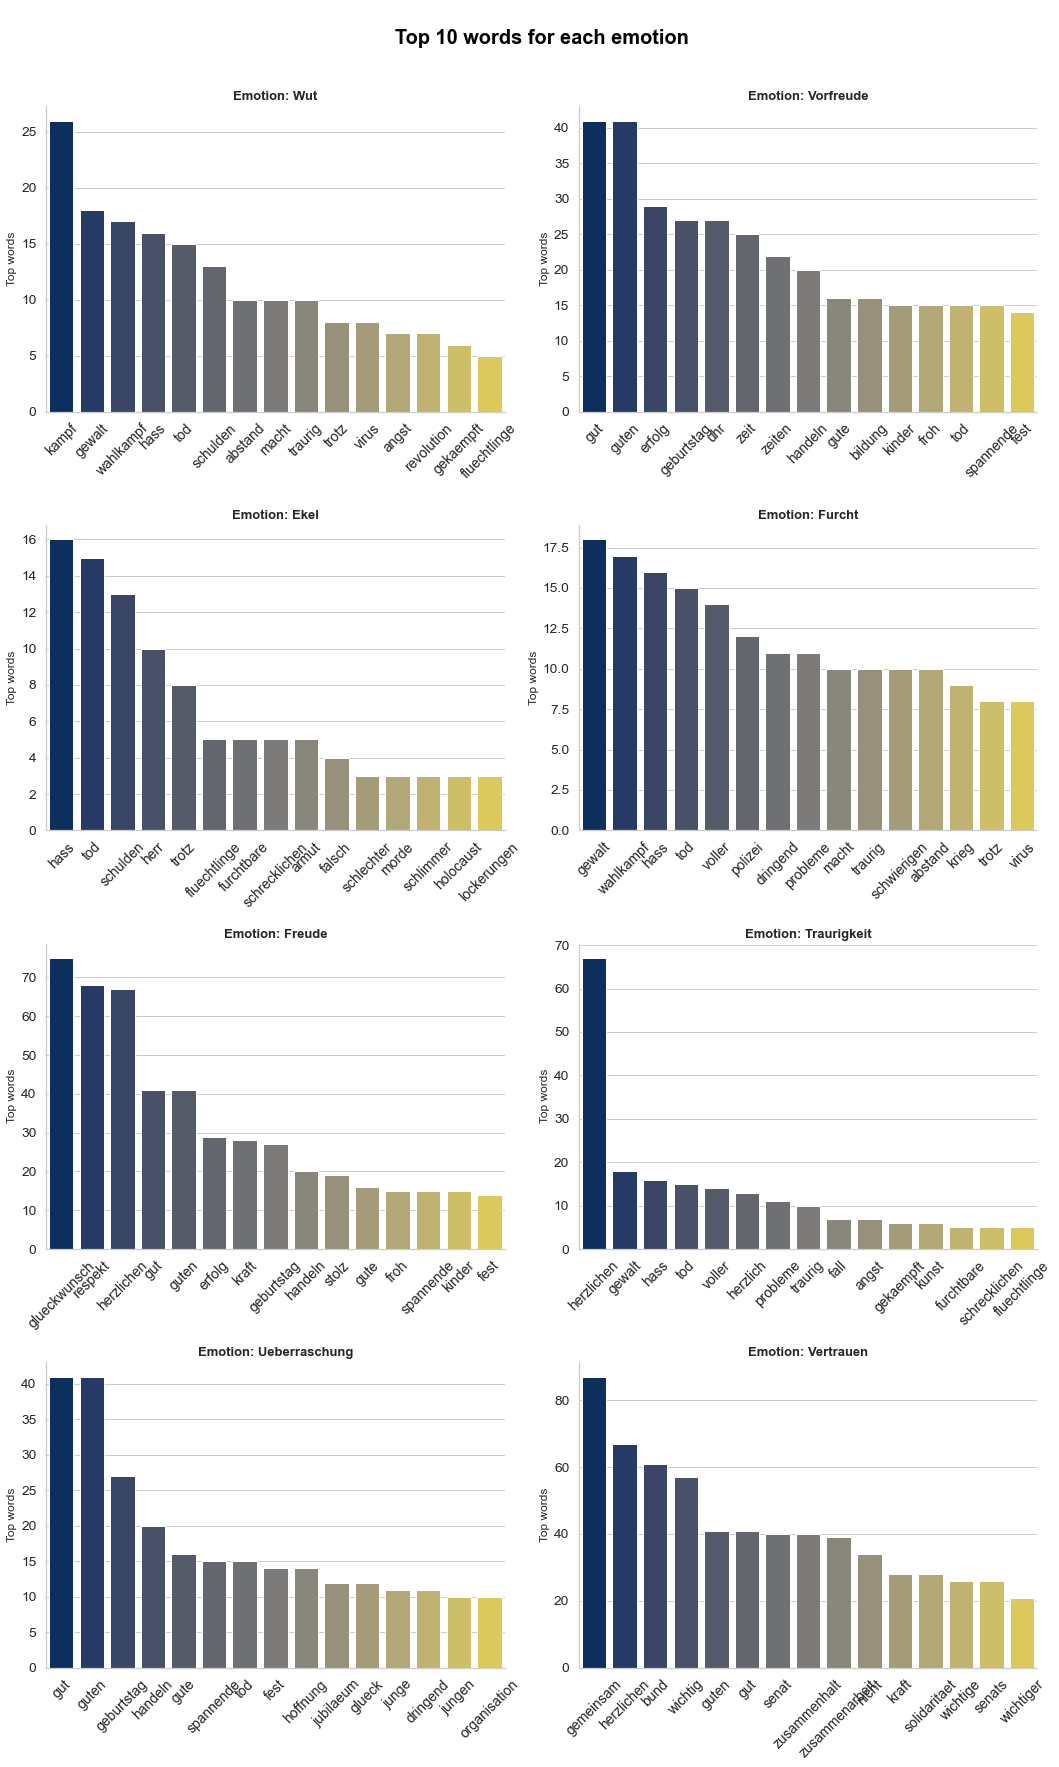

In [62]:
# Plotting the 15 words that contribute the most for each of the 8 emotions

fig, axs = plt.subplots(figsize=(15, 25), frameon=False) 
plt.box(False)
plt.axis('off')
plt.subplots_adjust(hspace = 1.6)
counter = 0

for i, emotion in enumerate(emotions): # for each emotioin

    # This is the dict that holds the top 15 words 
    words, top_words, top_words_indices = get_top_emotion_words(list_emotion_counts[i]['emo_frq'], 15)
    
    info = {'values' : [words[ind][1] for ind in top_words_indices], 
                      'labels' : [ind_to_word[word] for word in top_words]}
    sns.set(style="whitegrid")
    sns.set_context("notebook", font_scale=1.25)
    ax = fig.add_subplot(4, 2, counter+1) # plot 2 charts in each of the 4 rows
    sns.despine()
    ax = sns.barplot(x='labels', y='values', data=info, palette=("cividis"))
    plt.ylabel('Top words', fontsize=12)
    ax.set_title(label=str('Emotion: ') + emotion, fontweight='bold', size=13)
    plt.xticks(rotation=45, fontsize=14)
    counter += 1

axs.set_title(label='\nTop 10 words for each emotion\n', 
             fontweight='bold', size=20, pad=40)
plt.tight_layout()
#plt.savefig('images/Top10_words_per_emotion.png')

In [63]:
# Aggregating negative and positive emotions
df_emo['neg_emotions'] = df_emo['Traurigkeit'] + df_emo['Furcht'] + df_emo['Ekel'] + df_emo['Wut']
df_emo['pos_emotions'] = df_emo['Freude'] + df_emo['Vorfreude'] + df_emo['Vertrauen'] + df_emo['Ueberraschung']

In [64]:
#When neg_emotions is bigger 0 set true else false
df_emo['total_neg_emotions'] = df_emo['neg_emotions'].apply(lambda x: x > 0)
df_emo['total_pos_emotions'] = df_emo['pos_emotions'].apply(lambda x: x > 0)

In [65]:
df_emo

,tweetid,datetime,date,time,user,text,language,edited,textforttb,lematized,...,Ekel,Furcht,Freude,Traurigkeit,Ueberraschung,Vertrauen,neg_emotions,pos_emotions,total_neg_emotions,total_pos_emotions
12,1508125473842335749,2022-03-27 16:55:07,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...,de,saarlaenderinnen saarlaender klar wechsel spit...,Die Saarländerinnen und Saarländer haben sich ...,"['saarlaenderinnen', 'saarlaender', 'klar', 'w...",...,0,0,2,1,0,1,1,3,True,True
21,1504398354565976070,2022-03-17 10:04:52,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...,de,persoenliche position laengst bekannt zeitlich...,Meine persönliche Position ist längst bekannt:...,"['persoenliche', 'position', 'laengst', 'bekan...",...,0,0,0,0,0,0,0,0,False,False
54,1492872048120668161,2022-02-13 14:43:27,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",de,freue mich folgt alles regierungsarbeit betrif...,"Ich freue mich, wenn Sie und Ihr mir ab heute ...","['freue', 'mich', 'folgt', 'alles', 'regierung...",...,0,0,2,1,0,1,1,3,True,True
55,1492074452796022791,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...,de,aktuelle welle pandemie anlass zuversicht wiss...,Für die aktuelle Welle der Pandemie gibt es An...,"['aktuelle', 'pandemie', 'anlass', 'zuversicht...",...,0,0,1,0,1,1,0,4,False,True
56,1492074451432873985,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Die #Corona-Pandemie und auch die Flutkatastro...,de,coronapandemie flutkatastrophe sommer gezeigt ...,Die Corona-Pandemie und auch die Flutkatastrop...,"['coronapandemie', 'flutkatastrophe', 'sommer'...",...,0,0,0,0,0,1,0,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,1494245849085493251,2022-02-17 09:42:26,2022-02-17,09:42:26,38150247,Gestern Abend habe ich mit Biden zur Situation...,de,gestern abend biden situation ukraine telefoni...,Gestern Abend habe ich mit Biden zur Situation...,"['gestern', 'abend', 'biden', 'situation', 'uk...",...,0,0,0,0,0,0,0,0,False,False
50,1494003008283287560,2022-02-16 17:37:29,2022-02-16,17:37:29,38150247,Die #Corona-Regeln zeigen die erhoffte Wirkung...,de,coronaregeln zeigen erhoffte wirkung infektion...,Die Corona-Regeln zeigen die erhoffte Wirkung....,"['coronaregeln', 'zeigen', 'erhoffte', 'wirkun...",...,0,0,0,0,0,0,0,0,False,False
51,1493602211829587986,2022-02-15 15:04:51,2022-02-15,15:04:51,38150247,Ich habe Präsident #Putin in Moskau verdeutlic...,de,praesident putin moskau verdeutlicht deutschla...,Ich habe Präsident Putin in Moskau verdeutlich...,"['praesident', 'putin', 'moskau', 'verdeutlich...",...,0,0,0,0,0,1,0,1,False,True
52,1493599012691365903,2022-02-15 14:52:09,2022-02-15,14:52:09,38150247,Der Frieden und die Sicherheit in Europa sind ...,de,frieden sicherheit europa hohes gut lage ukrai...,Der Frieden und die Sicherheit in Europa sind ...,"['frieden', 'sicherheit', 'europa', 'hohes', '...",...,0,1,1,0,1,1,1,4,True,True


In [66]:
# Show dataframe for visualization

emotionDF

,tweetid,datetime,date,time,user,text,language,edited,textforttb,lematized,Personal Opinion (Subjectivity),Sentiment (Polarity),Analysis,word_count
12,1508125473842335749,2022-03-27 16:55:07,2022-03-27,16:55:07,38150247,Die Saarländerinnen und Saarländer haben sich ...,de,saarlaenderinnen saarlaender klar wechsel spit...,Die Saarländerinnen und Saarländer haben sich ...,"['saarlaenderinnen', 'saarlaender', 'klar', 'w...",0.000000,0.675000,positive,16
21,1504398354565976070,2022-03-17 10:04:52,2022-03-17,10:04:52,38150247,Meine persönliche Position ist längst bekannt:...,de,persoenliche position laengst bekannt zeitlich...,Meine persönliche Position ist längst bekannt:...,"['persoenliche', 'position', 'laengst', 'bekan...",0.000000,0.175000,positive,19
54,1492872048120668161,2022-02-13 14:43:27,2022-02-13,14:43:27,38150247,"Ich freue mich, wenn Sie und Ihr mir ab heute ...",de,freue mich folgt alles regierungsarbeit betrif...,"Ich freue mich, wenn Sie und Ihr mir ab heute ...","['freue', 'mich', 'folgt', 'alles', 'regierung...",0.000000,0.333333,positive,13
55,1492074452796022791,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Für die aktuelle Welle der Pandemie gibt es An...,de,aktuelle welle pandemie anlass zuversicht wiss...,Für die aktuelle Welle der Pandemie gibt es An...,"['aktuelle', 'pandemie', 'anlass', 'zuversicht...",0.000000,0.500000,positive,20
56,1492074451432873985,2022-02-11 09:54:05,2022-02-11,09:54:05,38150247,Die #Corona-Pandemie und auch die Flutkatastro...,de,coronapandemie flutkatastrophe sommer gezeigt ...,Die Corona-Pandemie und auch die Flutkatastrop...,"['coronapandemie', 'flutkatastrophe', 'sommer'...",0.000000,0.350000,positive,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,1494245849085493251,2022-02-17 09:42:26,2022-02-17,09:42:26,38150247,Gestern Abend habe ich mit Biden zur Situation...,de,gestern abend biden situation ukraine telefoni...,Gestern Abend habe ich mit Biden zur Situation...,"['gestern', 'abend', 'biden', 'situation', 'uk...",0.000000,0.000000,neutral,9
50,1494003008283287560,2022-02-16 17:37:29,2022-02-16,17:37:29,38150247,Die #Corona-Regeln zeigen die erhoffte Wirkung...,de,coronaregeln zeigen erhoffte wirkung infektion...,Die Corona-Regeln zeigen die erhoffte Wirkung....,"['coronaregeln', 'zeigen', 'erhoffte', 'wirkun...",0.166667,0.116667,neutral,10
51,1493602211829587986,2022-02-15 15:04:51,2022-02-15,15:04:51,38150247,Ich habe Präsident #Putin in Moskau verdeutlic...,de,praesident putin moskau verdeutlicht deutschla...,Ich habe Präsident Putin in Moskau verdeutlich...,"['praesident', 'putin', 'moskau', 'verdeutlich...",0.000000,0.000000,neutral,9
52,1493599012691365903,2022-02-15 14:52:09,2022-02-15,14:52:09,38150247,Der Frieden und die Sicherheit in Europa sind ...,de,frieden sicherheit europa hohes gut lage ukrai...,Der Frieden und die Sicherheit in Europa sind ...,"['frieden', 'sicherheit', 'europa', 'hohes', '...",0.000000,0.000000,neutral,10


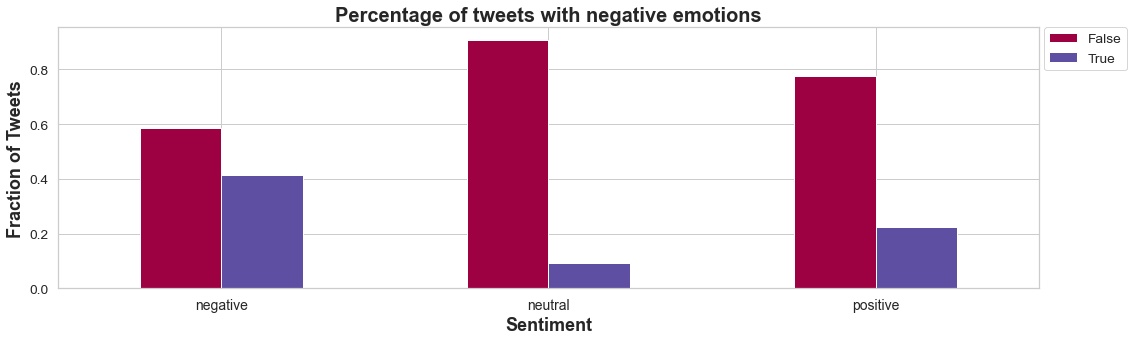

In [67]:
# Shows the percentage of tweets with certain sentiment and if the tweet has negative emotions
propsneg = df_emo.groupby('Analysis')['total_neg_emotions'].value_counts(normalize=True).unstack()

plot_fractions(propsneg,'Percentage of tweets with negative emotions','Percentage_of_Tweets_with_negative_emotions')

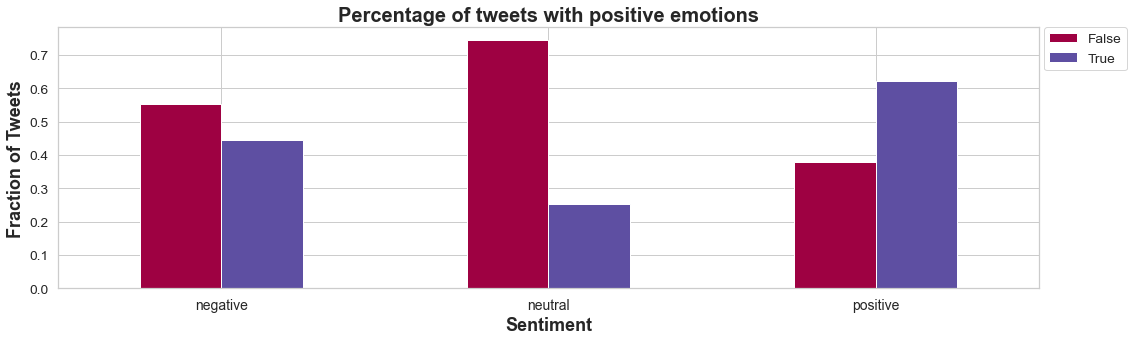

In [68]:
# Shows the percentage of tweets with certain sentiment and if the tweet has positive emotions
propspos = df_emo.groupby('Analysis')['total_pos_emotions'].value_counts(normalize=True).unstack()
plot_fractions(propspos,'Percentage of tweets with positive emotions','Percentage_of_Tweets_with_positive_emotions')

In [69]:
# Show negative tweets in each negative emotion column and mark negative words

df = df_emo[df_emo['Wut'] > 3]
print_colored_emotions(df['text'], ['Ekel','Traurigkeit','Wut','Furcht'], 'white', 'on_red')

Wir zeigen Rechtsextremismus die # RoteKarteGegenRechts ! Auch heute noch wollen Nazis und Rassisten ein Klima von Hass , Zwietracht & amp ; Angst schaffen . Sie lehnen all das ab , was unsere Gesellschaft zu einer guten Gesellschaft macht : Vielfalt , Zusammenhalt , Respekt und Solidarität . https : //t.co/cExlucjOoW 

Der Tod von Thomas Oppermann ist ein Schock für uns alle . Unser Land verliert einen versierten Politiker , der Bundestag einen herausragenden Vizepräsidenten und die SPD einen leidenschaftlichen und kämpferischen Genossen . Wir alle verlieren einen Freund - und sind traurig . 



In [70]:
# Show positive tweets in each positive emotion column and mark positive words

df2 = df_emo[df_emo['Vorfreude'] > 3]
print_colored_emotions(df2['text'], ['Freude','Vertrauen','Vorfreude', 'Ueberraschung'], 'white', 'on_green')

Zu den schönsten Sätzen des Jubilars zählt aus meiner Sicht : Partei gut , Fraktion gut , Regierung gut - Glück auf . Ganz in diesem Sinne : Herzlichen Glückwunsch zum 80 . Geburtstag , lieber Franz ! https : //t.co/IOKOlgRCpa 



In [71]:
# Show the percentage of tweets which share the emotion and sentiment 

df1 = df_emo.groupby(df_emo['Analysis'])[emotions].apply(lambda x:( x.sum()/x.count())*100)
df1.index = ['negative', 'neutral', 'positive']
df1.head()

,Wut,Vorfreude,Ekel,Furcht,Freude,Traurigkeit,Ueberraschung,Vertrauen
negative,41.666667,22.500000,30.000000,48.750000,18.750000,39.166667,18.750000,36.666667
neutral,5.451651,10.744131,2.705929,7.998408,9.948269,5.292479,5.491444,22.124950
positive,11.278793,34.471803,5.559968,14.297061,49.722002,15.091342,20.651311,71.644162


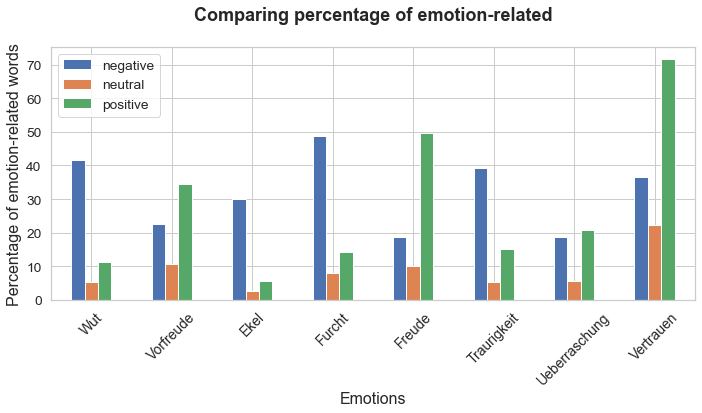

In [72]:
df_ =df1.T
df_.reset_index()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title(label='Comparing percentage of emotion-related\n', fontweight='bold', size=18)
df_.reset_index().plot(
    x="index", y=['negative', 'neutral', 'positive'], kind="bar", ax=ax
)

plt.xlabel("Emotions",fontsize = 16)
plt.ylabel("Percentage of emotion-related words",fontsize = 16)
plt.xticks(rotation=45,fontsize=14)
plt.tight_layout()
#plt.savefig('images/Percentage_emotions.png')

In [87]:
#Shit guide https://www.journaldev.com/46591/bag-of-words-model-in-python
"""from keras.preprocessing.text import Tokenizer

type(df_emo["text"])
listOfTweets = df_emo["text"].tolist()
type(listOfTweets)

model = Tokenizer()
model.fit_on_texts(listOfTweets)

rep = model.texts_to_matrix(listOfTweets, mode = "count")

print(rep)
type(model)
dir(model)"""

'from keras.preprocessing.text import Tokenizer\n\ntype(df_emo["text"])\nlistOfTweets = df_emo["text"].tolist()\ntype(listOfTweets)\n\nmodel = Tokenizer()\nmodel.fit_on_texts(listOfTweets)\n\nrep = model.texts_to_matrix(listOfTweets, mode = "count")\n\nprint(rep)\ntype(model)\ndir(model)'

In [89]:
df_emo.to_csv("EmotionCSV.csv")